In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import contextily as ctx
import sklearn.cluster as cl
import numpy as np
import time

import pickle

In [2]:
def make_geo(df: pd.DataFrame) -> geopandas.GeoDataFrame:
    """ Konvertovani dataframe do geopandas.GeoDataFrame se spravnym kodovani"""
    #df = df.loc[(df["d"] != None )&( df["e"]!=None)]
    df = df.dropna(subset=["d", "e"])

    return geopandas.GeoDataFrame(
        df, 
        geometry= geopandas.points_from_xy(df["d"], df["e"]),
        crs = "EPSG:5514"
        )


gdf = make_geo(pd.read_pickle("accidents.pkl.gz"))


/tmp/ipykernel_130/1292704120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf["date"] = pd.to_datetime(gdf["p2a"])


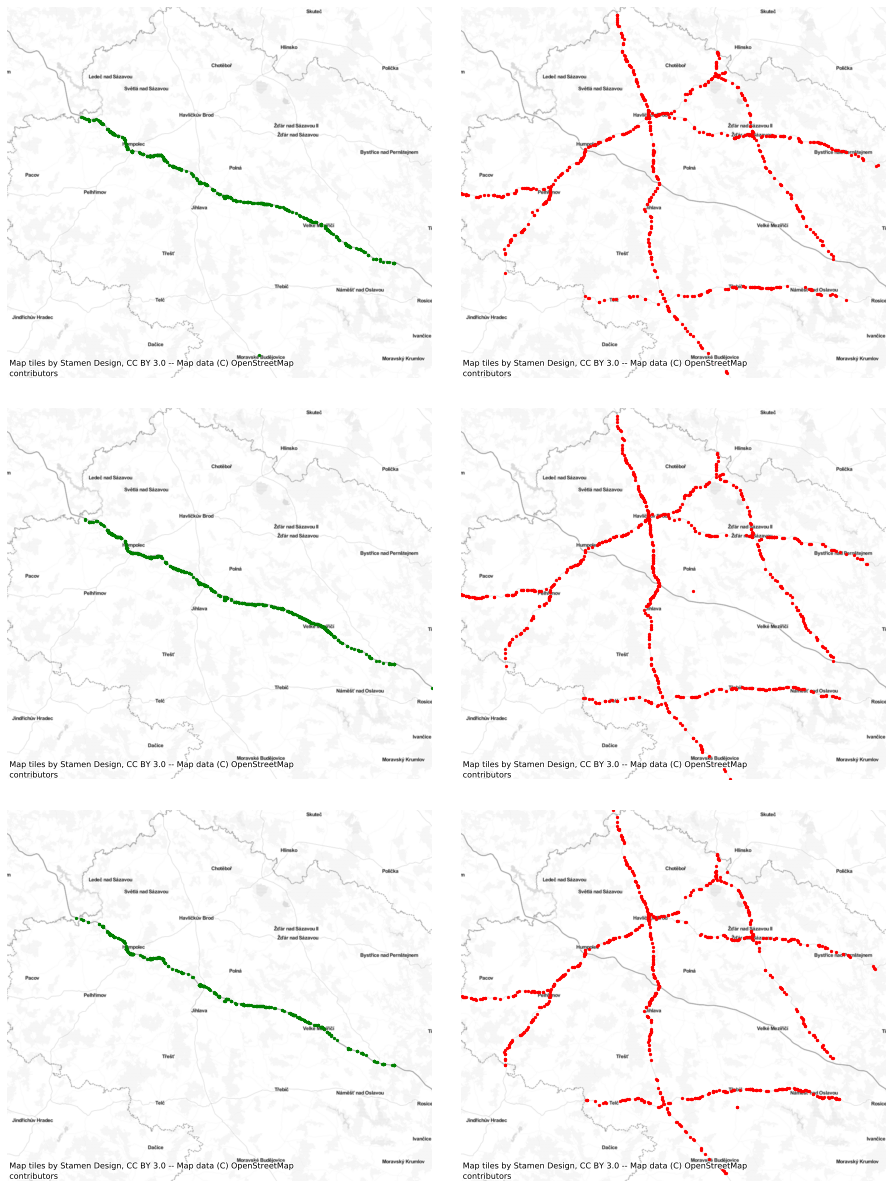

<Figure size 432x288 with 0 Axes>

In [53]:
def plot_geo(gdf: geopandas.GeoDataFrame, fig_location: str = None,
             show_figure: bool = False):
    """ Vykresleni grafu s sesti podgrafy podle lokality nehody 
     (dalnice vs prvni trida) pro roky 2018-2020 """
    #gdf = gdf.set_geometry(geopandas.points_from_xy(gdf["d"], gdf["e"]))

    gdf = gdf.loc[gdf["region"] == "VYS"]
    gdf["date"] = pd.to_datetime(gdf["p2a"])

    gdf = gdf.loc[(pd.DatetimeIndex(gdf["date"]).year >= 2018)&(pd.DatetimeIndex(gdf["date"]).year <= 2020)]
    gdf = gdf.loc[(gdf["p36"] == 0)|(gdf["p36"] == 1)]

    gdf = gdf.to_crs(epsg=3857)
    minx, miny, maxx,maxy = gdf.geometry.total_bounds

    fig, axs = plt.subplots(3, 2, figsize=(13,17))

    x_axis_i = 0
    y_axis_i = 0

    for road_type in [{"type":0, "color":"green"},{"type":1, "color":"red"}]:
        for year in [2018, 2019, 2020]:
            gdf[(gdf["p36"] == road_type["type"])&(pd.DatetimeIndex(gdf["date"]).year == year)].plot(ax=axs[y_axis_i,x_axis_i], markersize=5, color=road_type["color"])
            axs[y_axis_i,x_axis_i].axis("off")
            axs[y_axis_i,x_axis_i].set_xlim(minx, maxx)
            axs[y_axis_i,x_axis_i].set_ylim(miny, maxy)
            
            ctx.add_basemap(ax=axs[y_axis_i,x_axis_i], crs=gdf.crs.to_string(), source=ctx.providers.Stamen.TonerLite, alpha=0.9)
            
            # TODO: přidat labels pro každý obrázek
            y_axis_i += 1

        x_axis_i += 1
        y_axis_i = 0

    fig.tight_layout(pad=2.0)

    if(show_figure):
        plt.show()

    if(fig_location != None):
        plt.savefig(fig_location)

plot_geo(gdf, "geo1.png", True)

                                                  geometry  cnt
cluster                                                        
0        MULTIPOINT (-600846.718 -1146915.480, -600826....  338
1        MULTIPOINT (-542553.640 -1194726.258, -542262....  128
2        MULTIPOINT (-603952.255 -1192498.767, -603908....  153
3        MULTIPOINT (-655062.868 -1174703.858, -655048....   89
4        MULTIPOINT (-567654.381 -1184433.470, -567546....  156
5        MULTIPOINT (-583818.061 -1163561.598, -583814....  289
6        MULTIPOINT (-581175.095 -1208898.392, -581070....  133
7        MULTIPOINT (-623195.610 -1158967.736, -622071....  281
8        MULTIPOINT (-610188.806 -1125459.508, -609901....  390
9        MULTIPOINT (-569269.782 -1203782.509, -569168....  251
10       MULTIPOINT (-567376.162 -1154311.335, -567218....   98
11       MULTIPOINT (-604740.869 -1177732.960, -604729....  176
12       MULTIPOINT (-595172.086 -1209358.685, -595070....  343
13       MULTIPOINT (-554444.617 -118986

No handles with labels found to put in legend.


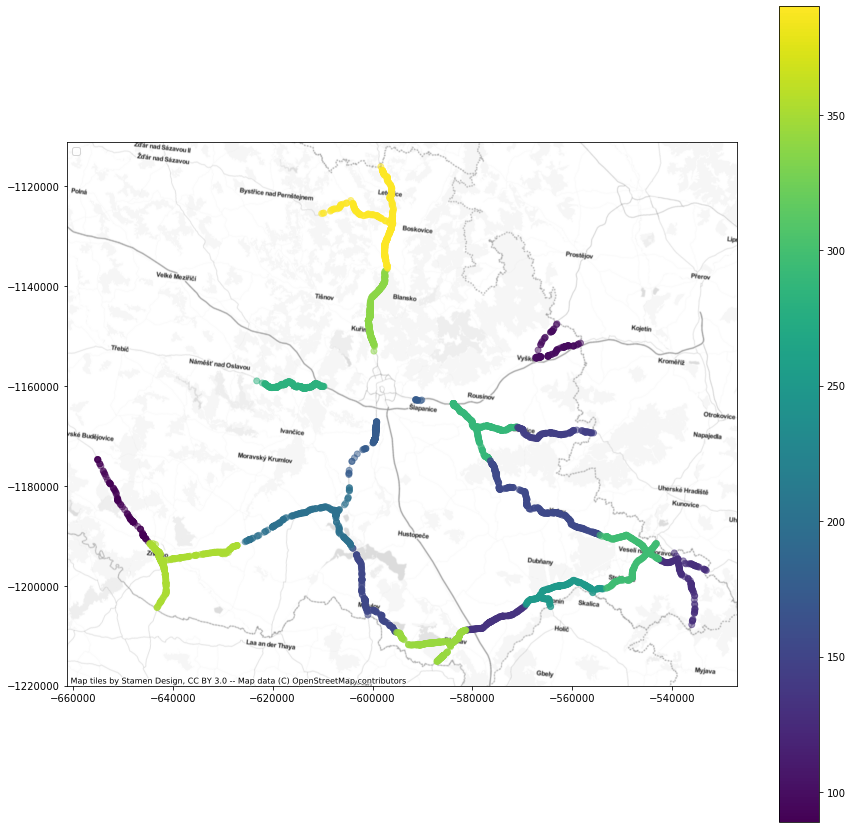

<Figure size 432x288 with 0 Axes>

In [41]:
def plot_cluster(gdf: geopandas.GeoDataFrame, fig_location: str = None,
                 show_figure: bool = False):
    """ Vykresleni grafu s lokalitou vsech nehod v kraji shlukovanych do clusteru """
    gdf = gdf.set_geometry(geopandas.points_from_xy(gdf["d"], gdf["e"]))
    gdf = gdf.loc[gdf["region"] == "JHM"]
    gdf = gdf.loc[gdf["p36"] == 1]
    gdf["cnt"] = gdf["region"].copy()


    coords = np.dstack([gdf.geometry.x, gdf.geometry.y]).reshape(-1,2)
    db = cl.MiniBatchKMeans(n_clusters=18).fit(coords)
    gdf4 = gdf.copy()
    gdf4["cluster"] = db.labels_

    
    
    gdf4 = gdf4.dissolve(by="cluster", aggfunc={"cnt":"count"})

    print(gdf4)

    fig = plt.figure(figsize=(15, 15))
    ax = plt.gca()
    #gdf4.convex_hull.plot(ax=ax, alpha=0.4)
    gdf4.plot(ax=ax, column="cnt", alpha=0.5, legend=True)

    ctx.add_basemap(ax=ax, crs=gdf.crs.to_string(), source=ctx.providers.Stamen.TonerLite, alpha=0.9)

    if(show_figure):
        plt.show()

    if(fig_location != None):
        plt.savefig(fig_location)    
   
    # vytvořit clustery KMeans

    # v polotu dát parametr column = "P"

plot_cluster(gdf, "geo2.png", True)

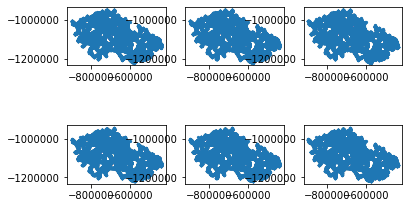

In [ ]:
if __name__ == "__main__":
    # zde muzete delat libovolne modifikace
    gdf = make_geo(pd.read_pickle("accidents.pkl.gz"))
    plot_geo(gdf, "geo1.png", True)
    plot_cluster(gdf, "geo2.png", True)
